In [1]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [2]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn import neighbors
import joblib

import matplotlib.pyplot as plt

Import necessary libraries


In [3]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [4]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [5]:
version='forPdata423_numPaths'


In [6]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [7]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [8]:
# data.head()

In [9]:
TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
len(TRAIN_FEATS)

312

In [10]:
# dataA=data.copy()

In [11]:
# data=dataA.loc[data.setNum==1,:]
# data.shape

In [12]:
unpaths=data.path.unique()

In [13]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


In [16]:
uniquePoints=data.loc[data.loc[:,['x','y']].duplicated()==False,['x','y']]
print('we have a target grid of',uniquePoints.shape[0],'unique points')
uniquePoints['pointNum']=np.arange(len(uniquePoints))
uniquePoints.head()

we have a target grid of 87 unique points


,x,y,pointNum
0,43.26,25.89,0
4,40.85,25.74,1
7,37.36,25.74,2
14,81.63,25.66,3
18,79.15,25.89,4


In [17]:
data=data.merge(uniquePoints,left_on=['x','y'],right_on=['x','y'])

In [21]:
data.groupby('path').pointNum.nunique().describe()

count    423.000000
mean      11.562648
std       10.421461
min        2.000000
25%        6.000000
50%        9.000000
75%       14.000000
max       84.000000
Name: pointNum, dtype: float64

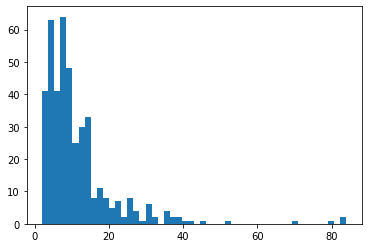

In [23]:
plt.hist(data.groupby('path').pointNum.nunique().values,50)
plt.show()

In [24]:
dataA=data.copy()

In [25]:
423*0.75,423*0.5,423*0.25

(317.25, 211.5, 105.75)

### CV TRAIN

In [28]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]
for rs in range(100):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=317,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)



    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        knn = neighbors.KNeighborsRegressor(45, weights='distance')
        val_predsXY = knn.fit(X_train, y_trainXY).predict(X_val)

        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')


0 mean validation error, 5-fold 2.4378132093960585
2.4378132093960585
---------------------
1 mean validation error, 5-fold 2.469644587599329
2.453728898497694
---------------------
2 mean validation error, 5-fold 2.4630939857044543
2.4568505942332806
---------------------
3 mean validation error, 5-fold 2.455767387840704
2.4565797926351363
---------------------
4 mean validation error, 5-fold 2.5151067315386726
2.4682851804158434
---------------------
5 mean validation error, 5-fold 2.435972091453869
2.4628996655888478
---------------------
6 mean validation error, 5-fold 2.475200585363527
2.4646569398423734
---------------------
7 mean validation error, 5-fold 2.4641543323010606
2.4645941138997096
---------------------
8 mean validation error, 5-fold 2.4768802735665534
2.4659592427515813
---------------------
9 mean validation error, 5-fold 2.433750936398536
2.4627384121162765
---------------------
10 mean validation error, 5-fold 2.439600261487888
2.4606349438773325
----------------

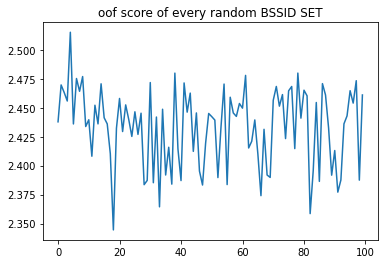

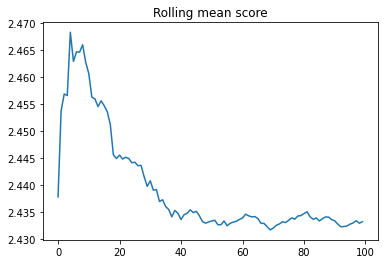

100
2.433218113744328
0.03293872219710554


In [29]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

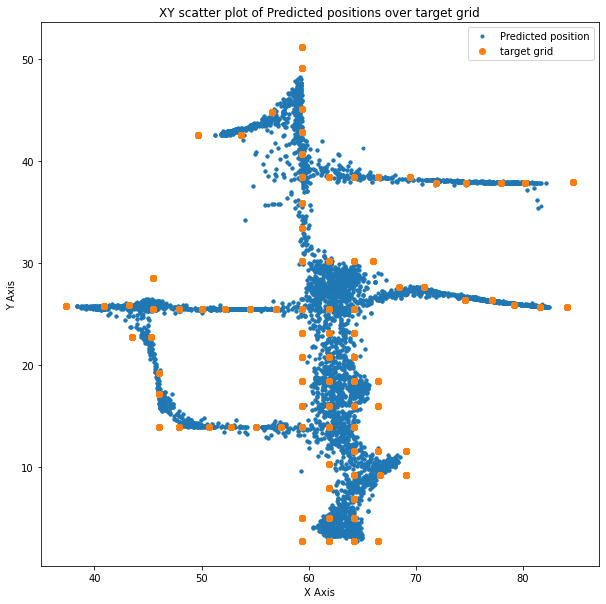

mean validation error, 5-fold 2.460996090375913


In [30]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

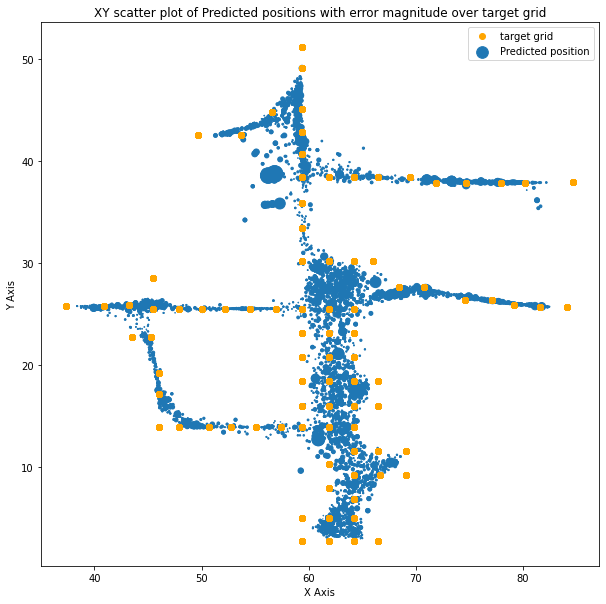

mean validation error, 5-fold 2.460996090375913


In [31]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [32]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]
for rs in range(100):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=211,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)



    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        knn = neighbors.KNeighborsRegressor(45, weights='distance')
        val_predsXY = knn.fit(X_train, y_trainXY).predict(X_val)

        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')


0 mean validation error, 5-fold 2.5078509663754756
2.5078509663754756
---------------------
1 mean validation error, 5-fold 2.5284016428013993
2.5181263045884377
---------------------
2 mean validation error, 5-fold 2.4502043348797797
2.495485648018885
---------------------
3 mean validation error, 5-fold 2.4947908459656003
2.495311947505564
---------------------
4 mean validation error, 5-fold 2.5747021103893335
2.511189980082318
---------------------
5 mean validation error, 5-fold 2.442595539498263
2.4997575733183086
---------------------
6 mean validation error, 5-fold 2.500832708601213
2.499911164073009
---------------------
7 mean validation error, 5-fold 2.4732723253356688
2.4965813092308418
---------------------
8 mean validation error, 5-fold 2.537323791893881
2.5011082517489576
---------------------
9 mean validation error, 5-fold 2.405416592857449
2.4915390858598068
---------------------
10 mean validation error, 5-fold 2.5633002581119584
2.4980628287918205
-----------------

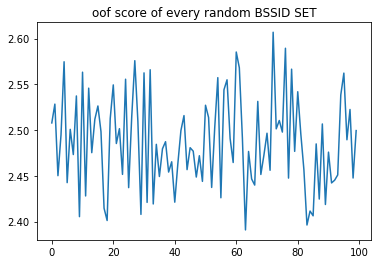

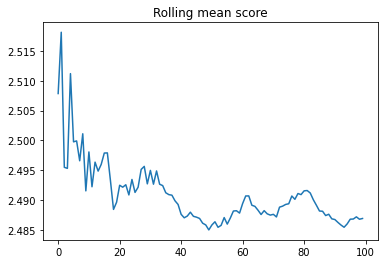

100
2.486910990414896
0.050323165137576405


In [33]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

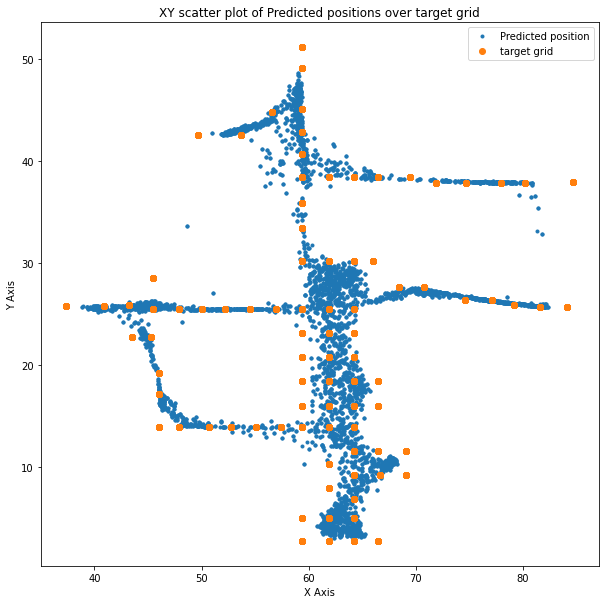

mean validation error, 5-fold 2.4994794153018844


In [34]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

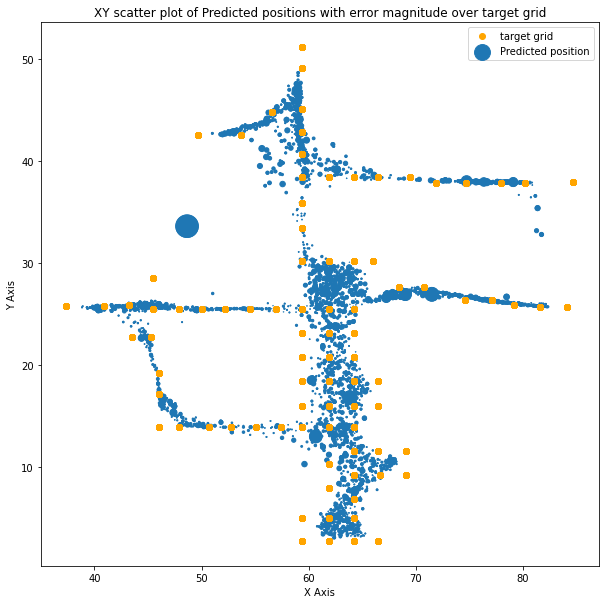

mean validation error, 5-fold 2.4994794153018844


In [35]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [36]:
# CROSS VALIDATION

name='KNeighbors'+version
scores=[]
for rs in range(100):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=106,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)



    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

        y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        knn = neighbors.KNeighborsRegressor(45, weights='distance')
        val_predsXY = knn.fit(X_train, y_trainXY).predict(X_val)

        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_valXY)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')


0 mean validation error, 5-fold 2.5559928936078187
2.5559928936078187
---------------------
1 mean validation error, 5-fold 2.720707530576591
2.638350212092205
---------------------
2 mean validation error, 5-fold 2.543906189863112
2.606868871349174
---------------------
3 mean validation error, 5-fold 2.625290395420329
2.6114742523669627
---------------------
4 mean validation error, 5-fold 2.7596270718327913
2.6411048162601283
---------------------
5 mean validation error, 5-fold 2.625706039628469
2.638538353488185
---------------------
6 mean validation error, 5-fold 2.5601168230003974
2.627335277704215
---------------------
7 mean validation error, 5-fold 2.5438002820343693
2.616893403245485
---------------------
8 mean validation error, 5-fold 2.7272665751443763
2.6291570890120286
---------------------
9 mean validation error, 5-fold 2.5623111592859056
2.6224724960394163
---------------------
10 mean validation error, 5-fold 2.700593812714909
2.629574433919007
--------------------

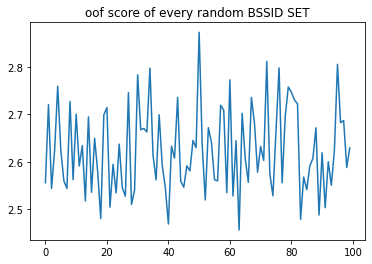

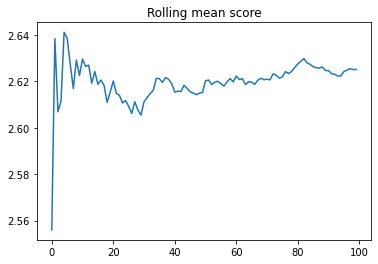

100
2.6250830844605195
0.0888602629566728


In [37]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

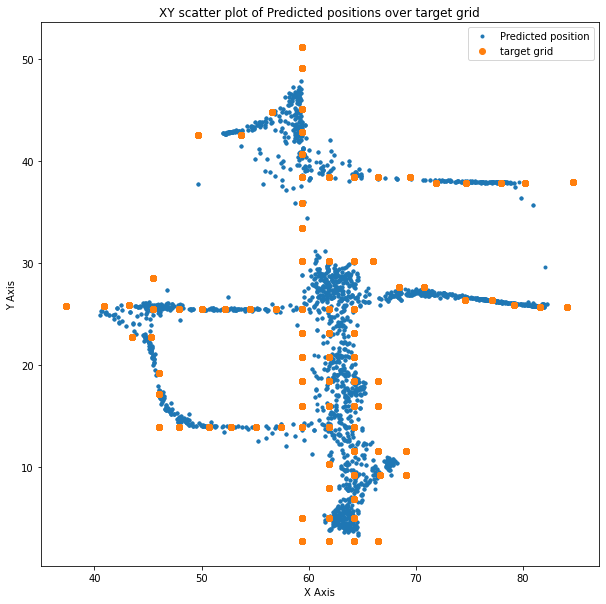

mean validation error, 5-fold 2.629437949210452


In [38]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

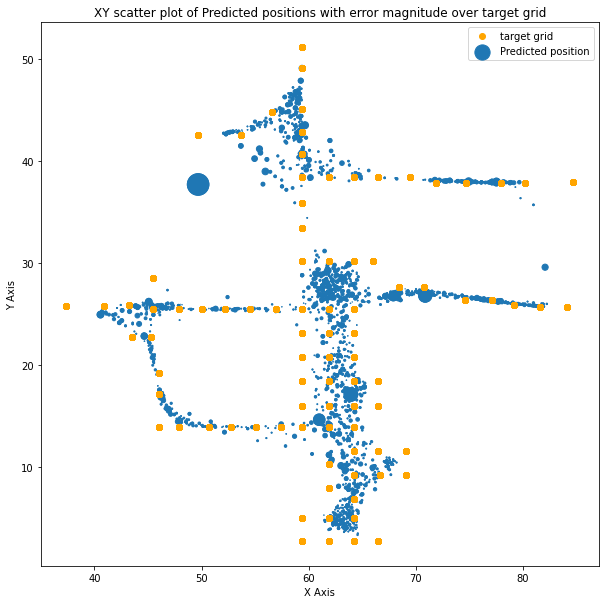

mean validation error, 5-fold 2.629437949210452


In [39]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
# pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/KNeighbors_'+version+'.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV_'+version+'.csv.gz', index=False, compression='gzip')

## Full train

In [ ]:


# name=version+'KNeighbors'



# train_paths=unpaths[:]

# train_paths=np.array(train_paths)

# X_train = data.loc[data.path.isin(train_paths), TRAIN_FEATS ].reset_index(drop=True)

# y_trainXY =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values
# knn = neighbors.KNeighborsRegressor(45, weights='distance')
# knn_model=knn.fit(X_train, y_trainXY)
# train_predsXY = knn_model.predict(X_train)

# print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_trainXY[:,0], y_trainXY[:,1]))


In [ ]:
# print('Save Knn model fully trained')
# joblib.dump(knn_model,'/gdrive/My Drive/Colab Notebooks/weights/'+name+'_model')